# Increase contrast in CT data scan

The current visualization techniques are effective for dense structures such as titanium plates and bones, which stand out clearly due to their high intensity values. However, adjacent soft tissues—like different muscle groups or muscle and fat—often have very similar densities, making it difficult to distinguish them visually in the current renderings.

In this notebook we will try to improve the visibility of those soft tissue boundaries by enhancing the edges using the Sobel kernel, a convolution-based filter that highlights areas of rapid intensity change.

#### Modules needed
``pip install opencv-python``

In [ ]:
%reset -f
import nrrd 
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
import numpy as np
import matplotlib.pyplot as plt
import cv2

filename = "data/ct_scan_knee_postop.nrrd"
data, header = nrrd.read(filename)

In [ ]:
def plot_histogram(data, bins=100, title="Histogram", log=True):
    """
    Plot a histogram of the input data.

    Parameters:
    - data: np.ndarray
        Input array (any shape).
    - bins: int
        Number of histogram bins.
    - title: str
        Title of the plot.
    - log: bool
        If True, use a logarithmic scale for the y-axis.
    """
    import matplotlib.pyplot as plt

    flattened = data.ravel()
    plt.figure(figsize=(8, 4))
    plt.hist(flattened, bins=bins, log=log)
    plt.title(title + (" (log scale)" if log else ""))
    plt.xlim(float(flattened.min()), float(flattened.max()))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

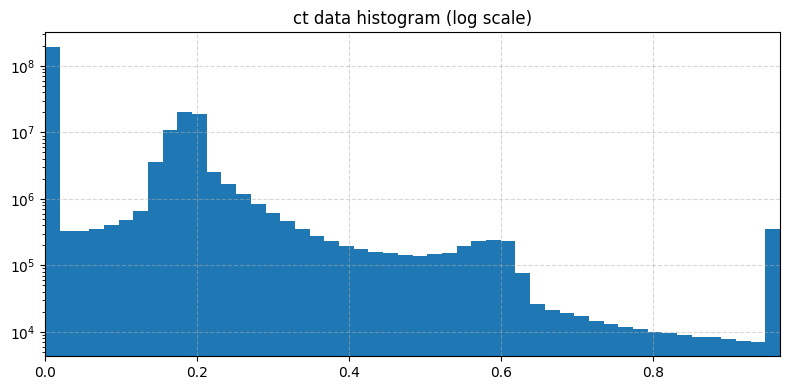

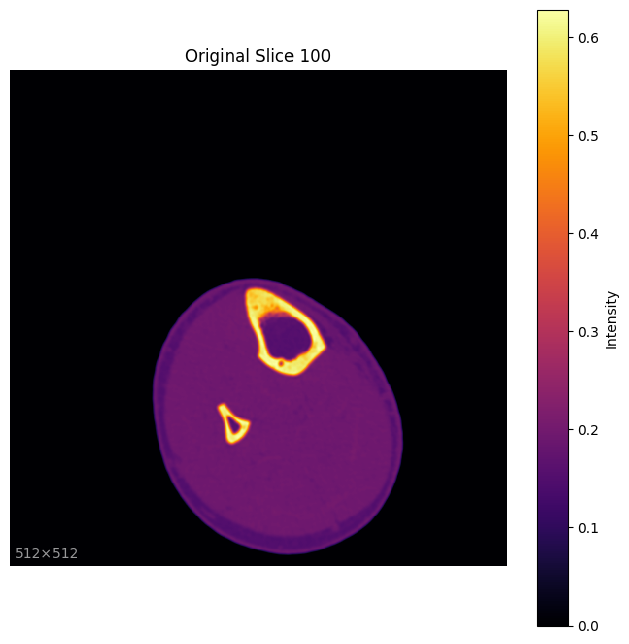

In [3]:
from lib.plothelpers import plot_image

# Select a slice
slice_index = 100
slice_data = data[slice_index] 

plot_histogram(data, bins=50, title="ct data histogram")
# Plot the slice
plot_image(slice_data, title=f"Original Slice {slice_index}")


In [4]:
from lib.plothelpers import plot_image

## Create derivative of data

In [5]:
from scipy.ndimage import gaussian_filter, sobel
import numpy as np

# Smooth first
sigma = 2  # Increase to get broader derivatives
smoothed = gaussian_filter(data, sigma=sigma)

# Then compute Sobel edges
sobel_x = sobel(smoothed, axis=0)
sobel_y = sobel(smoothed, axis=1)
sobel_z = sobel(smoothed, axis=2)

sobel_edges = np.sqrt(sobel_x**2 + sobel_y**2 + sobel_z**2)

# Normalize for visualization
# sobel_edges = (sobel_edges - sobel_edges.min()) / np.ptp(sobel_edges)

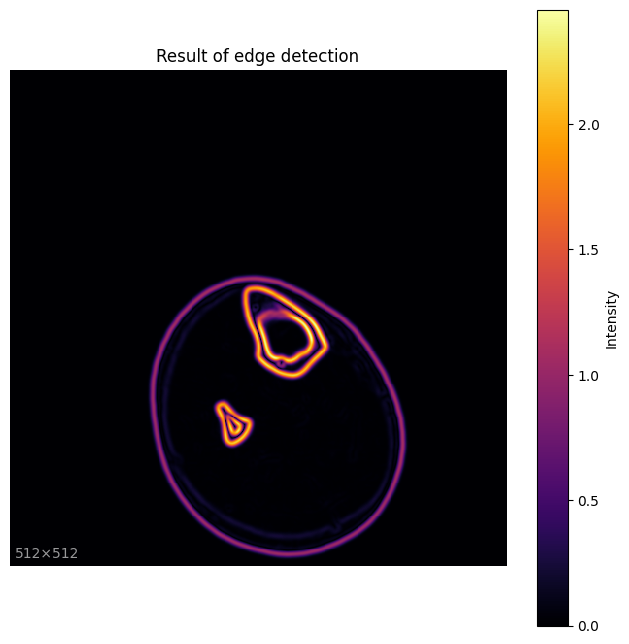

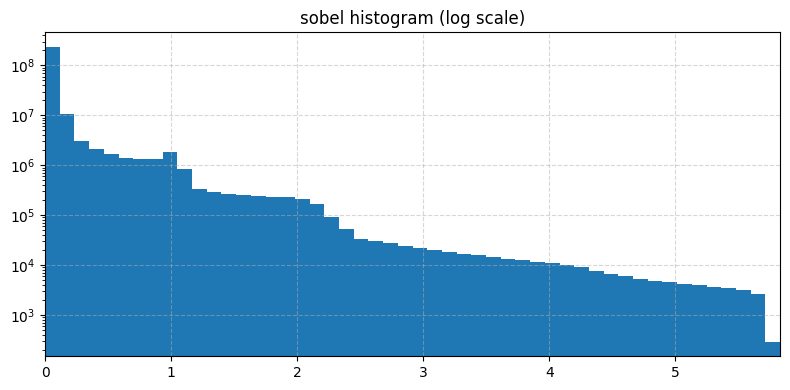

In [6]:
plot_image(sobel_edges[slice_index], title=f"Result of edge detection")
plot_histogram(sobel_edges, bins=50, title="sobel histogram")

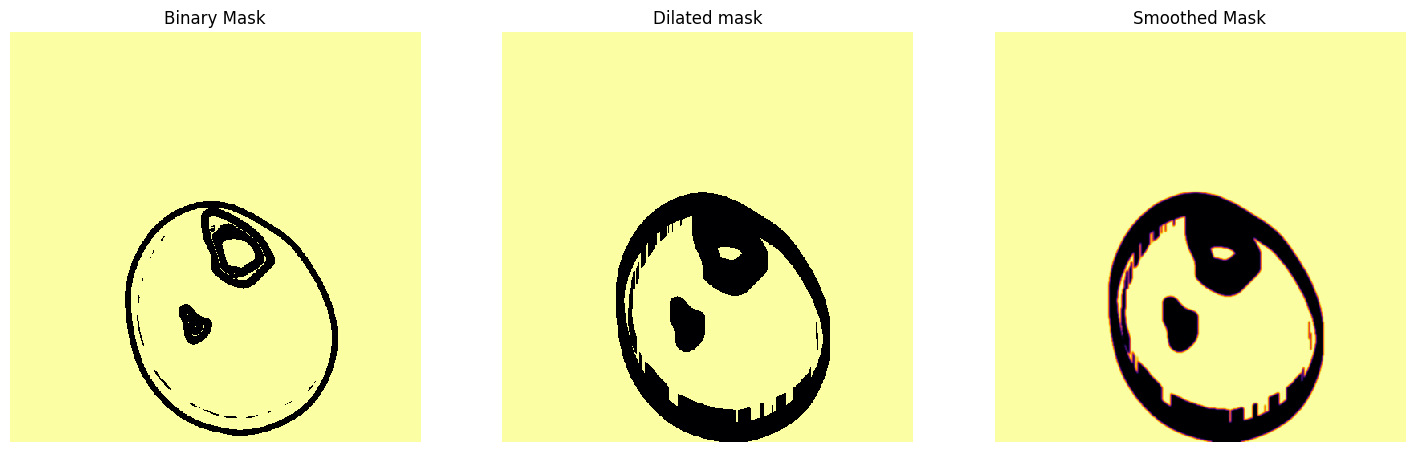

In [7]:
from lib.plothelpers import plot_comparison
from scipy.ndimage import gaussian_filter

threshold = 0.2
binary_mask = (sobel_edges < threshold).astype(np.uint8)  # Convert to 0 and 1

dilation_kernel_size = 19
dilation_kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
dilated_mask = cv2.erode(binary_mask, dilation_kernel, iterations=1)

smoothed_mask = gaussian_filter(dilated_mask.astype(np.float32), sigma=1)

plot_comparison((binary_mask[slice_index], dilated_mask[slice_index], smoothed_mask[slice_index]), 
                ("Binary Mask", "Dilated mask", "Smoothed Mask"))

Gate the derivative with the hard edge removal mask

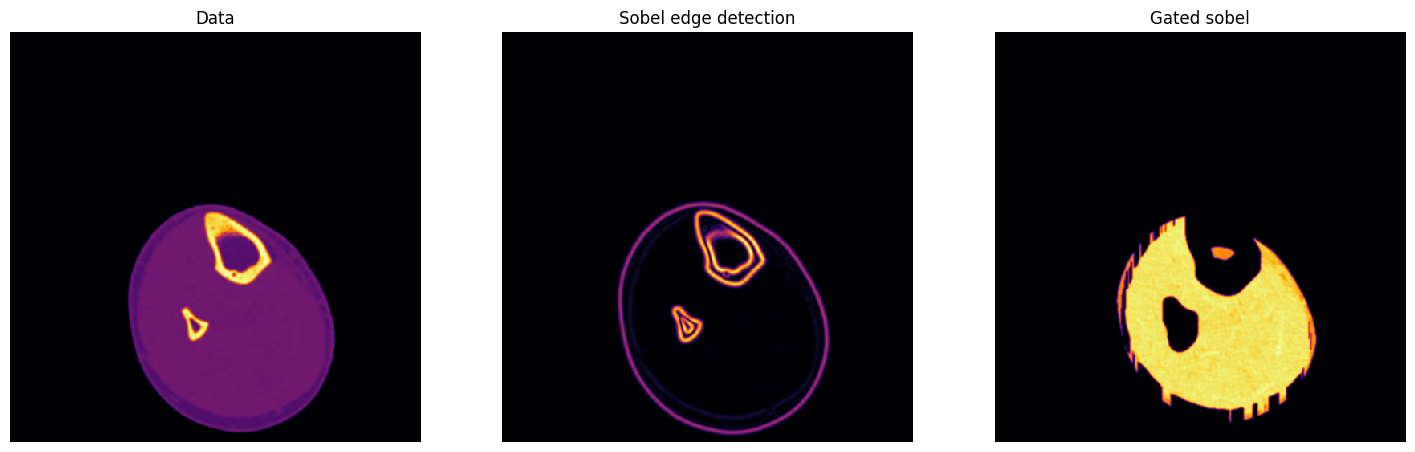

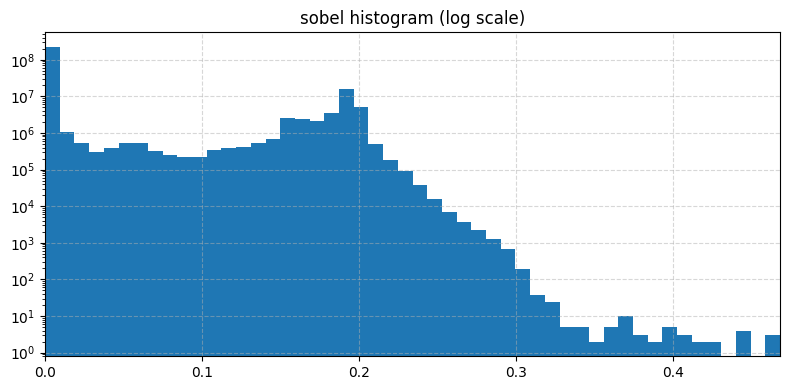

In [8]:
gated_sobel = np.clip(data * smoothed_mask, 0 ,1) 
plot_comparison((data[slice_index], sobel_edges[slice_index], gated_sobel[slice_index]), 
                ("Data", "Sobel edge detection", "Gated sobel"))
plot_histogram(gated_sobel, bins=50, title="sobel histogram", log=True)

In [9]:
from lib.nrrdtools import save_ct_nrrd
from lib.imageprocesing import filter_and_subsample

# Apply Gaussian filter and subsample by factor 3
sobel_edges_subsampled = filter_and_subsample(gated_sobel, subsampling_factor=3, sigma=1)

# Save the processed volume as compressed NRRD with proper header
output_filename = "data/ct_scan_knee_postop_sobel.nrrd"
save_ct_nrrd(output_filename, sobel_edges_subsampled)

Volume size before: (995, 512, 512), after: (332, 171, 171)
Saved as data/ct_scan_knee_postop_sobel.nrrd


## Tone curve

Before applying the edge detection we want to increase contrast in the value range where muscles reside. We do this by applying a modified signoid curve to the image

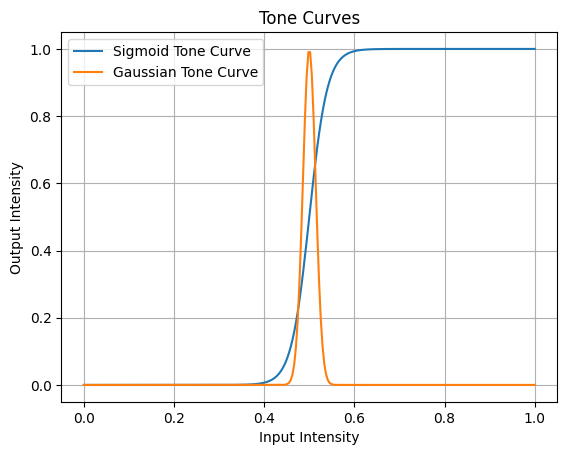

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def tone_curve(x, shift=0.5, contrast=10):
    """
    Sigmoid tone curve mapping [0,1] -> [0,1].
    """
    if not (0 <= shift <= 1):
        raise ValueError("shift must be between 0 and 1.")
    if contrast <= 0:
        raise ValueError("contrast must be greater than 0.")
    
    x = np.asarray(x)
    return 1 / (1 + np.exp(-contrast * (x - shift)))


def gaussian_tone_curve(x, shift=0.5, contrast=10):
    """
    Gaussian tone curve mapping [0,1] -> [0,1].

    Parameters:
    - x : np.ndarray or float
    - shift : float in [0,1], mean of Gaussian
    - contrast : float > 0, controls Gaussian width (inverse of std dev)
    """
    if not (0 <= shift <= 1):
        raise ValueError("shift must be between 0 and 1.")
    if contrast <= 0:
        raise ValueError("contrast must be greater than 0.")
    
    x = np.asarray(x)
    return 1 / np.exp((contrast * (x - shift) )**2)


# Visualize both curves
x = np.linspace(0, 1, 256)
y_sigmoid = tone_curve(x, shift=0.5, contrast=50)
y_gauss = gaussian_tone_curve(x, shift=0.5, contrast=50)

plt.plot(x, y_sigmoid, label="Sigmoid Tone Curve")
plt.plot(x, y_gauss, label="Gaussian Tone Curve")
plt.title("Tone Curves")
plt.xlabel("Input Intensity")
plt.ylabel("Output Intensity")
plt.grid(True)
plt.legend()
plt.show()


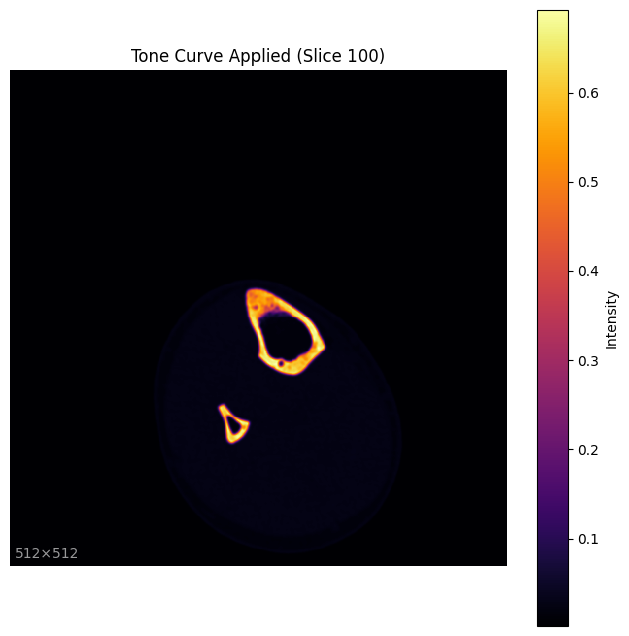

In [11]:

# Apply tone curve to the slice
adjusted_slice = gaussian_tone_curve(slice_data, shift=0.83, contrast=3)

plot_image(adjusted_slice, title=f"Tone Curve Applied (Slice {slice_index})")

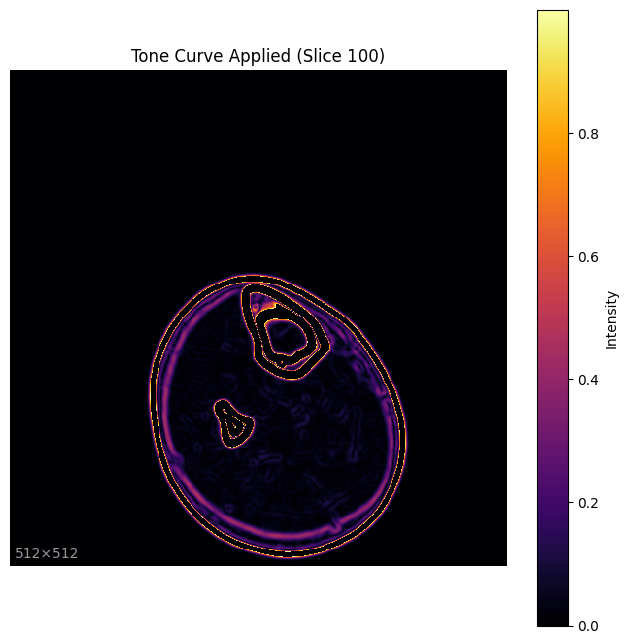

In [12]:
sobel_clamped = sobel_edges * 2
sobel_clamped[sobel_clamped > 1] = 0

plot_image(sobel_clamped[slice_index], title=f"Tone Curve Applied (Slice {slice_index})")